# Final Model for Animal Image Classification

## Setup and Import Required Libraries

In [47]:
# Importing libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:
import sys
import os

# Determine the project root directory
if '__file__' in globals():
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
else:
    # Manually set the project root if __file__ is not defined (e.g., in Jupyter notebook)
    project_root = os.path.abspath('..')
sys.path.append(project_root)

from models.mobilenet_v3 import MobileNetV3
from src.device_manager import DeviceDataLoader, get_default_device, to_device
from src.train_lr_scheduler import fit
from src.evaluate import evaluate
from src.plot import plot_losses, plot_accuracies
from src.FLOPs_counter import print_model_parm_flops

## Load Data

In [50]:
data_dir = '../dataset/animals/'
classes = os.listdir(data_dir)

In [51]:
# Image Transformations
transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

# Load Data
dataset = ImageFolder(data_dir, transform=transform)

print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [52]:
# Splitting the dataset to training, validation, and testing category
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print('Size of training dataset:', len(train_ds))
print('Size of validation dataset:', len(val_ds))
print('Size of test dataset:', len(test_ds))

Size of training dataset: 5330
Size of validation dataset: 313
Size of test dataset: 627


## Data Preprocessing

In [53]:
# Image Transformations
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_ds.dataset.transform = train_transform

In [54]:
# Data loaders
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [55]:
# Move data to device (GPU or CPU)
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

## Model Initialization

In [56]:
num_classes = len(classes) # 151 classes

# Initialize the model
model = MobileNetV3(num_classes)
print(model)

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(

In [57]:
# Move model to the device
model = to_device(model, device)

## Model Training

In [58]:
# Evaluate the model before training
history = [evaluate(model, val_dl)]
history_not_trained = history
print("Before training: ", history_not_trained)

Before training:  [{'val_loss': 5.087026596069336, 'val_acc': 0.02812500111758709}]


In [59]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

# Train the model
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1/10, Learning Rate: 0.001


100%|██████████| 334/334 [00:08<00:00, 38.98it/s]


Epoch [0], train_loss: 2.1249, val_loss: 1.6200, val_acc: 0.8375
Epoch 2/10, Learning Rate: 0.001


100%|██████████| 334/334 [00:08<00:00, 39.48it/s]


Epoch [1], train_loss: 0.6951, val_loss: 0.9196, val_acc: 0.9007
Epoch 3/10, Learning Rate: 0.001


100%|██████████| 334/334 [00:08<00:00, 40.16it/s]


Epoch [2], train_loss: 0.4052, val_loss: 0.9773, val_acc: 0.9187
Epoch 4/10, Learning Rate: 0.001


100%|██████████| 334/334 [00:08<00:00, 40.20it/s]


Epoch [3], train_loss: 0.2836, val_loss: 1.2200, val_acc: 0.9069
Epoch 5/10, Learning Rate: 0.0001


100%|██████████| 334/334 [00:08<00:00, 39.62it/s]


Epoch [4], train_loss: 0.1204, val_loss: 0.9237, val_acc: 0.9194
Epoch 6/10, Learning Rate: 0.0001


100%|██████████| 334/334 [00:08<00:00, 39.77it/s]


Epoch [5], train_loss: 0.0561, val_loss: 0.9600, val_acc: 0.9351
Epoch 7/10, Learning Rate: 1e-05


100%|██████████| 334/334 [00:08<00:00, 40.00it/s]


Epoch [6], train_loss: 0.0426, val_loss: 0.8049, val_acc: 0.9406
Epoch 8/10, Learning Rate: 1e-05


100%|██████████| 334/334 [00:08<00:00, 40.38it/s]


Epoch [7], train_loss: 0.0433, val_loss: 0.9848, val_acc: 0.9406
Epoch 9/10, Learning Rate: 1e-05


100%|██████████| 334/334 [00:08<00:00, 41.19it/s]


Epoch [8], train_loss: 0.0330, val_loss: 0.9331, val_acc: 0.9382
Epoch 10/10, Learning Rate: 1.0000000000000002e-06


100%|██████████| 334/334 [00:07<00:00, 44.33it/s]


Epoch [9], train_loss: 0.0381, val_loss: 0.8643, val_acc: 0.9375


In [60]:
# Save training history
torch.save(history, '../results/mobilenet_v3_history.pth')

In [61]:
# Save the model
torch.save(model.state_dict(), '../results/mobilenet_v3.pth')

## Model Evaluation

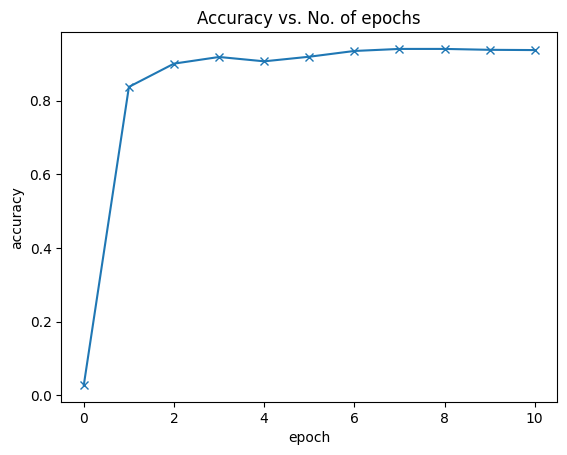

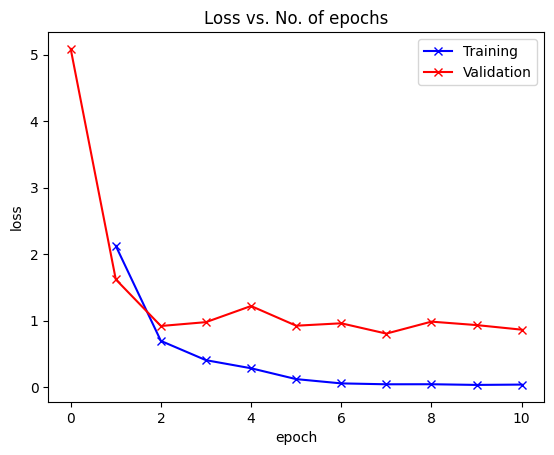

In [62]:
# Plot the accuracies and losses
plot_accuracies(history)
plot_losses(history)

In [63]:
# Evaluate the model after training
val = evaluate(model, test_dl)
print("Accuracy:", val['val_acc'])

Accuracy: 0.9593750238418579


In [64]:
# Number of FLOPs
input = torch.randn(1, 3, 224, 224).to(device)
flops = print_model_parm_flops(model, input, detail=True)

Number of FLOPs: 0.4285576343536377
Conv FLOPs: 0.405146816
Linear FLOPs: 0.00284672
Batch Norm FLOPs: 0.017599232
ReLU FLOPs: 0.002315392
Pooling FLOPs: 0.0006494640256278217
